# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

print("Libraries imported successfully! Ready for the mission.")

Libraries imported successfully! Ready for the mission.


In [42]:
# ==============================================================================
# PART 1: Data Generation (The Exclusion Zone)
# ==============================================================================


GROUP_NUMBER = 5

# Set seed for reproducibility so everyone gets the same "random" data
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    # We use .float() to make it compatible with math operations later
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


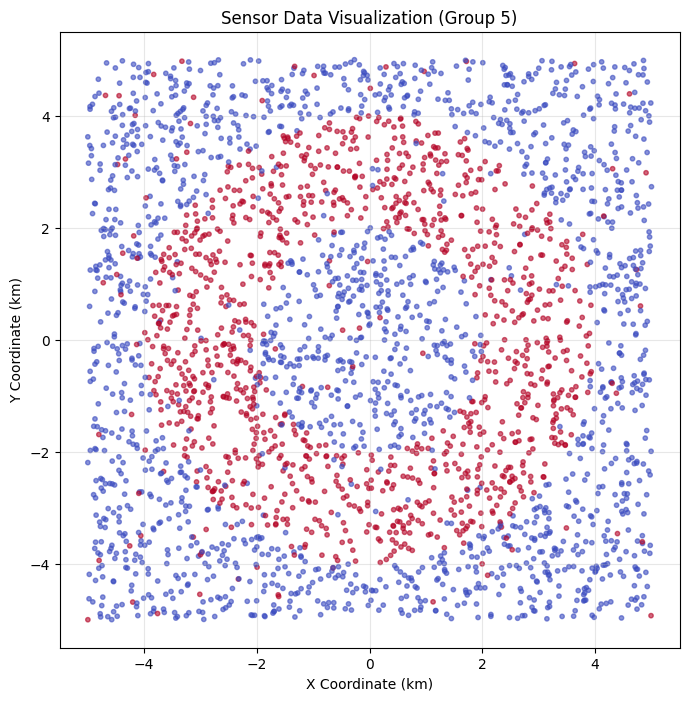

We can clearly see the 'Dead Zone' ring, plus some noisy dots scattered around.


In [43]:
# Let's plot the data to verify the "Donut" shape
plt.figure(figsize=(8, 8))
plt.scatter(X_full[:, 0], X_full[:, 1], c=y_full[:, 0], cmap='coolwarm', s=10, alpha=0.6)
plt.title(f"Sensor Data Visualization (Group {GROUP_NUMBER})")
plt.xlabel("X Coordinate (km)")
plt.ylabel("Y Coordinate (km)")
plt.grid(True, alpha=0.3)
plt.show()

print("We can clearly see the 'Dead Zone' ring, plus some noisy dots scattered around.")

In [44]:
# Convert tensors to numpy for sklearn split, then back to tensors
X_np = X_full.numpy()
y_np = y_full.numpy()

# 70% Train, 30% Validation
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_np, y_np, test_size=0.3, random_state=GROUP_NUMBER)

# Convert back to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")

Training Set: torch.Size([2100, 2])
Validation Set: torch.Size([900, 2])


In [45]:
def sigmoid(x):
    """Standard Sigmoid function: 1 / (1 + e^-x)"""
    return 1.0 / (1.0 + torch.exp(-x))

def relu(x):
    """ReLU function: max(0, x)"""
    return torch.clamp(x, min=0)

def forward_pass(X):
    """
    The forward pass through the network using matrix multiplication (torch.matmul or @)
    """
    # Layer 1
    z1 = torch.matmul(X, W1) + b1
    a1 = relu(z1) # Activation

    # Layer 2
    z2 = torch.matmul(a1, W2) + b2
    a2 = relu(z2)

    # Layer 3
    z3 = torch.matmul(a2, W3) + b3
    a3 = relu(z3)

    # Output Layer
    z4 = torch.matmul(a3, W4) + b4
    y_pred = sigmoid(z4) # Final probability between 0 and 1

    return y_pred

In [46]:
def binary_cross_entropy(y_true, y_pred):
    """
    Manual implementation of BCE Loss.
    """
    # Clip predictions to avoid log(0) which gives NaN
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)

    # The Formula
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss

def calculate_accuracy(y_true, y_pred):
    # Round predictions to 0 or 1
    predicted_classes = (y_pred > 0.5).float()
    correct_predictions = (predicted_classes == y_true).float().sum()
    return correct_predictions / y_true.shape[0]

In [47]:
# Hyperparameters
epochs = 5000       # How many times to loop through data
learning_rate = 0.05

# Network Architecture (Input: 2, Hidden: 16x3, Output: 1)
input_size = 2
hidden_size = 16
output_size = 1

# Initialize Weights and Biases
# W1 (Input to Hidden 1)
W1 = torch.randn(input_size, hidden_size, requires_grad=True)
b1 = torch.zeros(hidden_size, requires_grad=True)

# W2 (Hidden 1 to Hidden 2)
W2 = torch.randn(hidden_size, hidden_size, requires_grad=True)
b2 = torch.zeros(hidden_size, requires_grad=True)

# W3 (Hidden 2 to Hidden 3)
W3 = torch.randn(hidden_size, hidden_size, requires_grad=True)
b3 = torch.zeros(hidden_size, requires_grad=True)

# W4 (Hidden 3 to Output)
W4 = torch.randn(hidden_size, output_size, requires_grad=True)
b4 = torch.zeros(output_size, requires_grad=True)

# Lists to store history for plotting later
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Starting Training Protocol...")

for epoch in range(epochs):

    # --- 1. Forward Pass (Training) ---
    y_pred_train = forward_pass(X_train)

    # --- 2. Calculate Loss ---
    loss = binary_cross_entropy(y_train, y_pred_train)

    # --- 3. Backward Pass (Calculate Gradients) ---
    # We clear old gradients first!
    if W1.grad is not None:
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        W3.grad.zero_()
        b3.grad.zero_()
        W4.grad.zero_()
        b4.grad.zero_()

    loss.backward() # This magically fills .grad for our W and b variables

    # --- 4. Optimization (Manual Update) ---
    # We use torch.no_grad() because we don't want to track these updates in the computational graph
    with torch.no_grad():
        W1 -= learning_rate * W1.grad
        b1 -= learning_rate * b1.grad
        W2 -= learning_rate * W2.grad
        b2 -= learning_rate * b2.grad
        W3 -= learning_rate * W3.grad
        b3 -= learning_rate * b3.grad
        W4 -= learning_rate * W4.grad
        b4 -= learning_rate * b4.grad

    # --- 5. Validation Check (Every 100 epochs) ---
    if epoch % 100 == 0:
        # Calculate Validation Loss/Acc without tracking gradients
        with torch.no_grad():
            y_pred_val = forward_pass(X_val)
            val_loss = binary_cross_entropy(y_val, y_pred_val)

            # Calculate Accuracies
            train_acc = calculate_accuracy(y_train, y_pred_train)
            val_acc = calculate_accuracy(y_val, y_pred_val)

            # Store history
            train_losses.append(loss.item())
            val_losses.append(val_loss.item())
            train_accs.append(train_acc.item())
            val_accs.append(val_acc.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Val Loss={val_loss.item():.4f}, Val Acc={val_acc.item():.4f}")

print("Training Complete!")

Starting Training Protocol...
Epoch 0: Train Loss=6.1015, Val Loss=nan, Val Acc=0.6156
Epoch 500: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 1000: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 1500: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 2000: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 2500: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 3000: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 3500: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 4000: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Epoch 4500: Train Loss=nan, Val Loss=nan, Val Acc=0.6156
Training Complete!


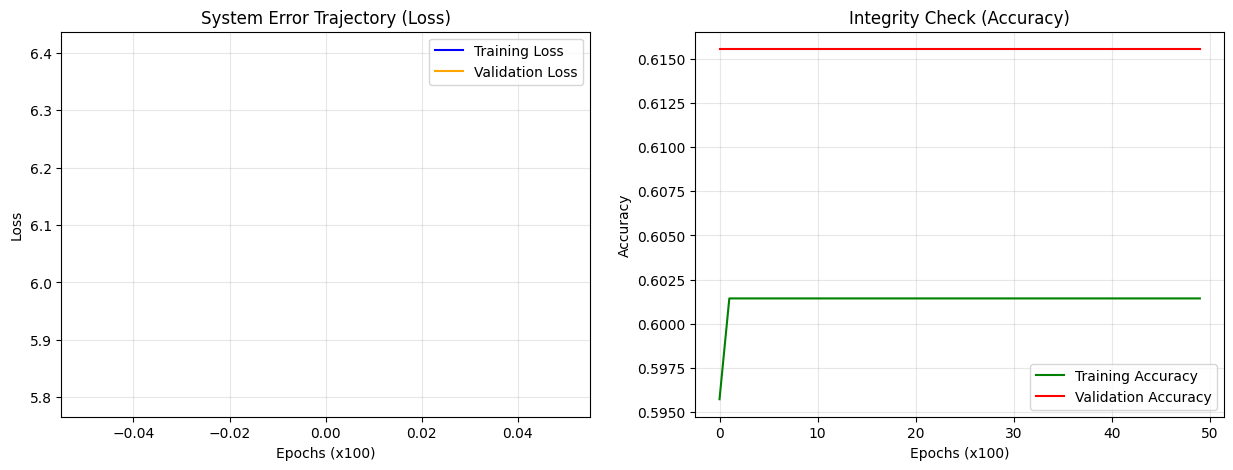

In [48]:
# Create the figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='orange')
ax1.set_title("System Error Trajectory (Loss)")
ax1.set_xlabel("Epochs (x100)")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy
ax2.plot(train_accs, label='Training Accuracy', color='green')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_title("Integrity Check (Accuracy)")
ax2.set_xlabel("Epochs (x100)")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()

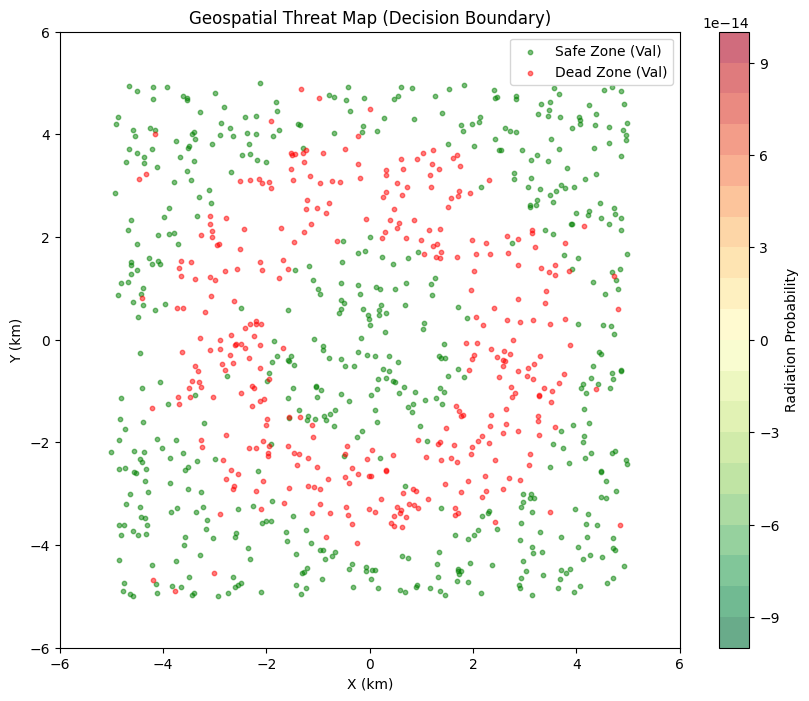

If you see a Red Ring (Donut) matching the points, the Mission is a Success!


In [49]:
# Geospatial Threat Map (Decision Boundary)

# 1. Create a meshgrid (a grid of points covering the -5 to 5 area)
x_range = np.linspace(-6, 6, 200)
y_range = np.linspace(-6, 6, 200)
xx, yy = np.meshgrid(x_range, y_range)

# Flatten the grid to feed into the model
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# 2. Get predictions for the whole grid
with torch.no_grad():
    grid_preds = forward_pass(grid_tensor)
    grid_preds = grid_preds.reshape(xx.shape)

# 3. Plotting
plt.figure(figsize=(10, 8))

# Plot the contours (The Decision Boundary)
# We draw the "confidence" regions.
contour = plt.contourf(xx, yy, grid_preds, levels=20, cmap='RdYlGn_r', alpha=0.6)
plt.colorbar(contour, label='Radiation Probability')

# Overlay the Validation Data points to see how well it fits
# Safe Zone (0) = Blue, Dead Zone (1) = Red
plt.scatter(X_val_np[y_val_np[:,0]==0, 0], X_val_np[y_val_np[:,0]==0, 1],
            c='green', s=10, alpha=0.5, label='Safe Zone (Val)')
plt.scatter(X_val_np[y_val_np[:,0]==1, 0], X_val_np[y_val_np[:,0]==1, 1],
            c='red', s=10, alpha=0.5, label='Dead Zone (Val)')

plt.title("Geospatial Threat Map (Decision Boundary)")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.legend(loc='upper right')
plt.show()

print("If you see a Red Ring (Donut) matching the points, the Mission is a Success!")